# Setup

In [1]:
# Standard Python libraries
import sys
import random
import string
import os
import math

# Third party libraries
from pylibdmtx.pylibdmtx import encode
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Custom funcs
sys.path.append('../scripts')
from hourglass import *

cuda


In [2]:
# Some kinda global params
input_size = 256
output_size = 64
n_stacks = 3

# Gaussian distribution (spread) for heatmap generation
sigma = 2

n_train = 800
n_val = 100
n_test = 100

THINS TO TRY:
- smaller heatmaps
- more different stacks
- some optimization of gpu usage for faster training...
- ...?

losses:
- test 0.06 with 3 stacks and varying epochs/patiences
- test 2.09 with 6 stacks and varying epochs/patiences
- test 36.09 with 6 stacks and early stopping patiences 1 and all epochs 100
- test 0.16 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 5 instead of old of 2)
- test 2.34 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 10 instead of old of 2)
- test 0.13 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 3 instead of old of 2)
- test 0.15 with 3 stacks and varying epochs/patiences and wider heatmaps (sigma = 2 - should be exactly like the first run!)

# Data Synthesis

In [3]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''

    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))

    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode, dmc_size):
    '''Creates a PIL image containing DMC encoding of given string'''

    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels)

    # upscale image
    img = img.resize((dmc_size, dmc_size), Image.NEAREST)

    return img

def get_corner_coords(img, debug=False):
    '''Returns the coordinates of corners of DMC'''
    padding = 26 # Padding around DMC info zone in pixels (we only want inner modules!)

    raw_coords = [] # Raw pixel coords of dmc corners
    label_info = [] # Line by line label info

    # Get coords of each corner of DMC
    top_left = (padding-1, padding-1)
    top_right = (img.width-padding, padding-1)
    bottom_left = (padding-1, img.height-padding)
    bottom_right = (img.width-padding, img.height-padding)

    # Paint corners red for viz/debug
    if debug:
        img = img.convert('RGB')
        img.putpixel(top_left, (255, 0, 0))
        img.putpixel(top_right, (255, 0, 0))
        img.putpixel(bottom_left, (255, 0, 0))
        img.putpixel(bottom_right, (255, 0, 0))

    # Normalize pixel coords to 0-1
    top_left_norm = [top_left[0] / img.width, top_left[1] / img.height]
    top_right_norm = [top_right[0] / img.width, top_right[1] / img.height]
    bottom_left_norm = [bottom_left[0] / img.width, bottom_left[1] / img.height]
    bottom_right_norm = [bottom_right[0] / img.width, bottom_right[1] / img.height]

    # Add raw coords
    raw_coords.extend([top_left, top_right, bottom_left, bottom_right])

    # Add normalized coords
    label_info.extend([top_left_norm, top_right_norm, bottom_left_norm, bottom_right_norm])

    return raw_coords, label_info, img

def get_heatmaps(img, raw_coords, heatmap_size, sigma=2, debug=False):
    '''Returns heatmaps for each corner of DMC'''

    # Create empty heatmaps
    heatmaps = np.zeros((4, heatmap_size, heatmap_size))

    # Create gaussian heatmaps for each corner
    for i in range(4):
        # Create gaussian heatmap
        heatmap = np.zeros((img.height, img.width))
        for y in range(img.height):
            for x in range(img.width):
                heatmap[y, x] = np.exp(-((x - raw_coords[i][0])**2 + (y - raw_coords[i][1])**2) / (2 * sigma**2))  # Sigma = std of the Gaussian distribution

        # Scale to heatmap_size x heatmap_size
        heatmap = cv2.resize(heatmap, (heatmap_size, heatmap_size))

        # Add heatmap to heatmaps
        heatmaps[i] = heatmap

    # Paint heatmaps on image for viz/debug
    if debug:
        # Scale heatmaps to image size
        debug_heatmaps = []
        for i in range(4):
            debug_heatmaps.append(cv2.resize(heatmaps[i], (img.width, img.height)))
        for i in range(4):
            for y in range(img.height):
                for x in range(img.width):
                    if debug_heatmaps[i][y, x] > 0:
                        img.putpixel((x, y), (int(debug_heatmaps[i][y, x] * 255), 0, 0))

    return heatmaps

def get_texture_crop(textures_path, size, debug=False):
    '''Gets a random texture image from the given path and returns a random crop'''

    texture = random.choice(os.listdir(textures_path))

    if debug:
        print(texture)

    texture = Image.open(os.path.join(textures_path, texture))

    # get random crop
    transform = v2.Compose([
        v2.RandomCrop((size, size))
    ])
    texture = transform(texture)

    return texture

81_Circular Scratched metal PBR texture-seamless.jpg


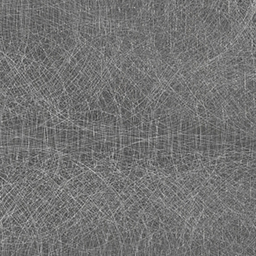

In [4]:
# Testing texture crops (uncomment debug print)
get_texture_crop('../data/textures/', size=input_size, debug=True)

[(25, 25), (230, 25), (25, 230), (230, 230)]
[[0.09765625, 0.09765625], [0.8984375, 0.09765625], [0.09765625, 0.8984375], [0.8984375, 0.8984375]]
(4, 256, 256)
(256, 256)
[[1.38511937e-68 6.33199997e-66 2.25434814e-63 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.33199997e-66 2.89464031e-63 1.03056333e-60 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.25434814e-63 1.03056333e-60 3.66905962e-58 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


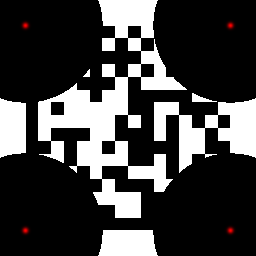

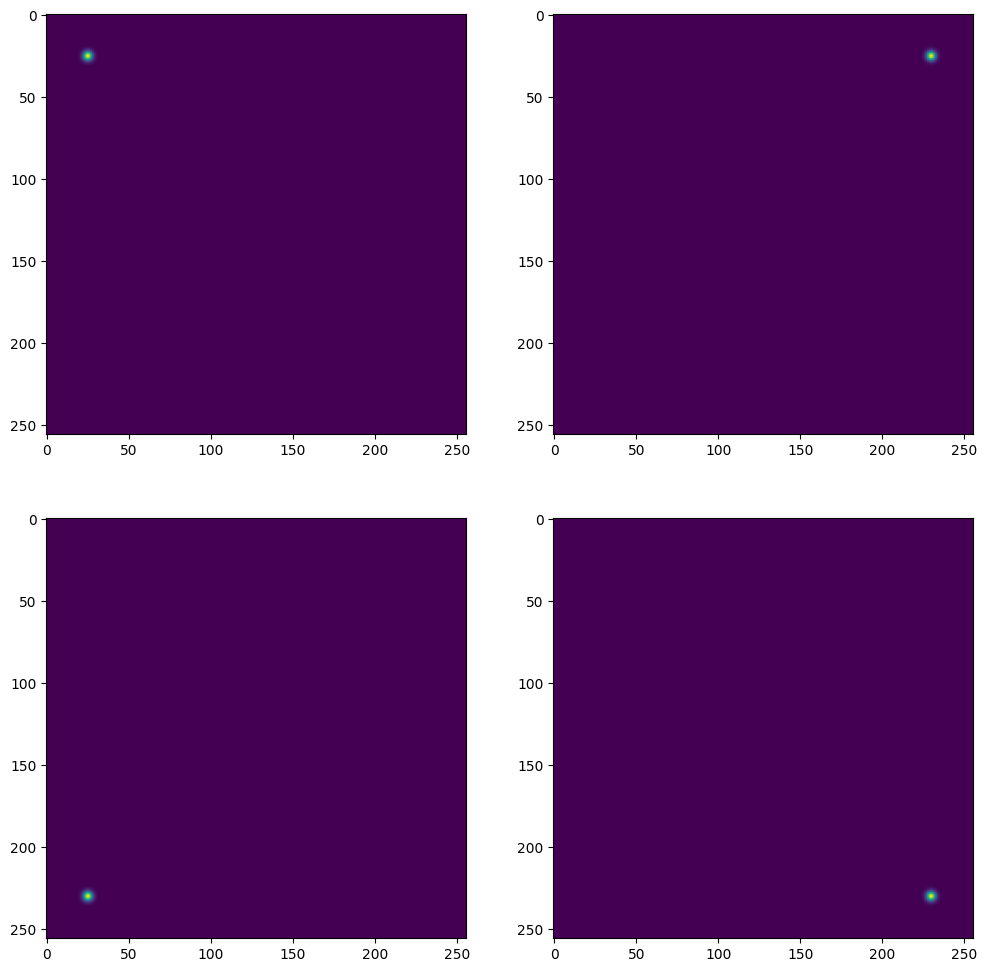

In [5]:
# Testing functions
test = gen_string()
img = encode_image(test, dmc_size=input_size)
raw_coords, label_info, img = get_corner_coords(img, debug=True)
print(raw_coords)
print(label_info)
heatmaps = get_heatmaps(img, raw_coords, heatmap_size=input_size, sigma=sigma, debug=True)
print(heatmaps.shape)
print(heatmaps[0].shape)
print(heatmaps[0])

# Display image
display(img)

# Display heatmaps
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    heatmap = heatmaps[i]
    # scale up to input size
    heatmap = cv2.resize(heatmap, (input_size, input_size))
    plt.imshow(heatmap)
plt.show()

In [6]:
def gen_save(type, input_size):
    '''Generates a random serial number, encodes it into a DMC image, and saves it to train/val/test folders'''

    to_encode = gen_string()
    img = encode_image(to_encode, dmc_size=input_size)

    # Get corner values
    raw_coords, label_info, img = get_corner_coords(img)

    # Get heatmaps
    heatmaps = get_heatmaps(img, raw_coords, heatmap_size=input_size, sigma=sigma, debug=False)

    # Convert heatmaps to tensor
    heatmaps = torch.tensor(heatmaps).float()

    # Normalize image
    img = np.array(img)
    img = img / 255
    img = torch.tensor(img).float()
    img = img.permute(2, 0, 1) # Change to having channel dim first

    # Generate random texture crop (size should match input for model)
    texture = get_texture_crop('../data/textures/', size=input_size)

    # Normalize texture
    texture = np.array(texture)
    texture = texture / 255
    texture = torch.tensor(texture).float()
    texture = texture.permute(2, 0, 1) # Change to having channel dim first

    # Combine image, texture, and heatmaps into single tensor
    img = torch.cat((img, texture, heatmaps), dim=0)

    # Save image texture heatmaps wombo combo
    torch.save(img, f'../data/hourglass_localization_rectification/{type}/{to_encode}.pt')

    return

def delete_old():
    '''Deletes all images and labels in train/val/test folders'''

    for folder in ['train', 'val', 'test']:
        for file in os.listdir(f'../data/hourglass_localization_rectification/{folder}'):
            os.remove(f'../data/hourglass_localization_rectification/{folder}/{file}')

    return

In [7]:
# Delete old synth data
delete_old()

In [8]:
# Generating train/val/test datasets
print(f'Generating {n_train} train images...')
for i in range(n_train - len(os.listdir('../data/hourglass_localization_rectification/train'))):
    gen_save('train', input_size=input_size)

print(f'Generating {n_val} val images...')
for i in range(n_val - len(os.listdir('../data/hourglass_localization_rectification/val'))):
    gen_save('val', input_size=input_size)

print(f'Generating {n_test} test images...')
for i in range(n_test - len(os.listdir('../data/hourglass_localization_rectification/test'))):
    gen_save('test', input_size=input_size)

Generating 800 train images...
Generating 100 val images...
Generating 100 test images...


In [9]:
# Test file
def load_test_file():
    '''Loads a test file for inspection'''

    test_file = '../data/hourglass_localization_rectification/train/' + os.listdir('../data/hourglass_localization_rectification/train')[0]
    test_tensor = torch.load(test_file)

    print(test_file)
    return test_tensor
_ = load_test_file()

../data/hourglass_localization_rectification/train/0A0O73069550055.pt


../data/hourglass_localization_rectification/train/0A0O73069550055.pt


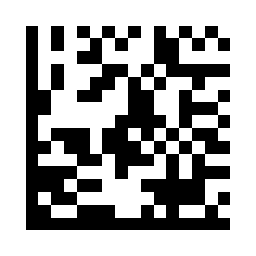

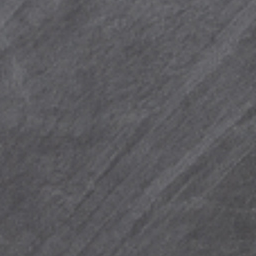

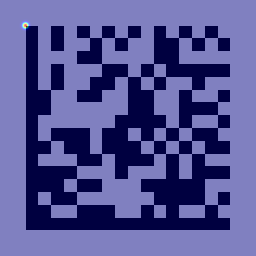

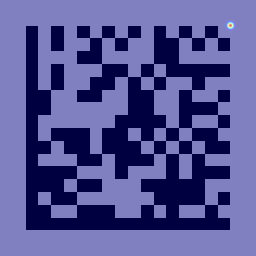

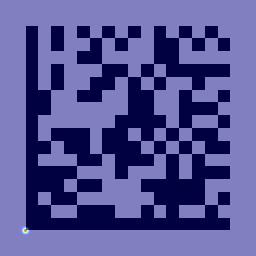

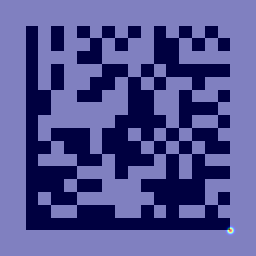

In [10]:
# Helper for presenting images / creating PIL images
def tensors2PIL(tensor, size, debug=False):
    # Split into DMC and texture images
    dmc = tensor[:3].numpy()
    texture = tensor[3:6].numpy()
    heatmap = tensor[6:].numpy()

    # Multiply by 255 to convert to 0-255 range
    dmc = dmc * 255
    texture = texture * 255

    # Ensure no values are above 255
    dmc[dmc > 255] = 255
    texture[texture > 255] = 255

    # Convert to uint8
    dmc = dmc.astype(np.uint8)
    texture = texture.astype(np.uint8)

    # Reshape dmc to 3D
    dmc = dmc.reshape(3, size, size).transpose(1, 2, 0)

    # Reshape texture to 3D
    texture = texture.reshape(3, size, size).transpose(1, 2, 0)

    # Reshape heatmaps to 2D
    heatmaps = []
    for i in range(4):
        heatmaps.append(heatmap[i].reshape(size, size))

    # Convert to PIL images
    dmc = Image.fromarray(dmc).convert('L')
    texture = Image.fromarray(texture).convert('RGB')
    for idx, heatmap in enumerate(heatmaps):
        heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply color map
        dmc_tmp = cv2.cvtColor(np.array(dmc), cv2.COLOR_GRAY2RGB)
        overlay = cv2.addWeighted(dmc_tmp, 0.5, heatmap_colored, 0.5, 0) # Blend images
        heatmap_img = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        heatmaps[idx] = Image.fromarray(heatmap_img)

    if debug:
        display(dmc)
        display(texture)
        for heatmap in heatmaps:
            display(heatmap)

    return dmc, texture, heatmaps

test_tensor = load_test_file()
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A0O73069550055.pt


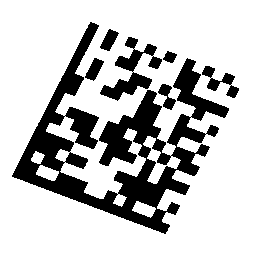

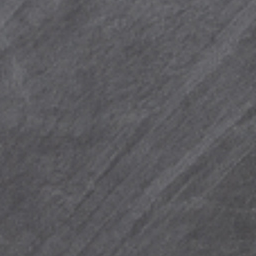

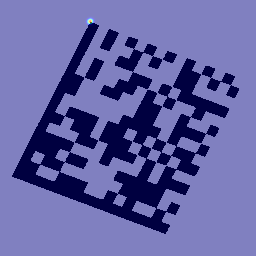

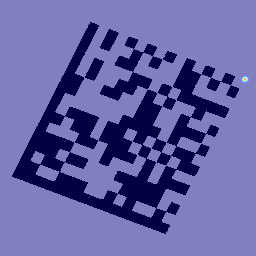

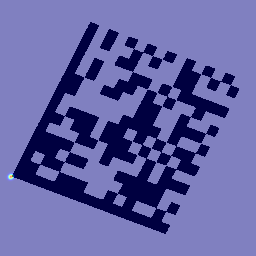

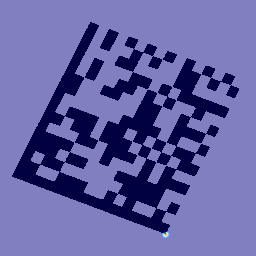

In [11]:
def flood_fill(tensor_image, x, y):
    '''Finds and fills all connected black pixels in image starting from x, y'''
    rows, cols = tensor_image.shape[-2], tensor_image.shape[-1]
    visited = set()
    stack = [(x, y)]

    connected_pixels = []

    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))

        # Ensure it's within bounds and is black
        if 0 <= cx < rows and 0 <= cy < cols and tensor_image[cx, cy] == 0:
            connected_pixels.append((cx, cy))

            # Add neighbors (if not at the edge of the image)
            if cx > 0:
                stack.append((cx-1, cy))
            if cx < rows-1:
                stack.append((cx+1, cy))
            if cy > 0:
                stack.append((cx, cy-1))
            if cy < cols-1:
                stack.append((cx, cy+1))
    
    for idx in connected_pixels:
        tensor_image[idx[0], idx[1]] = 1
    
    return tensor_image

def shape_transform(tensor):
    '''Applies random shape transformations to image'''

    # Split into DMC and heatmaps
    dmc = tensor[:3]
    heatmaps = tensor[6:]

    # Temporarily downsize dmc to 1 channel to allow for next steps (IMPORTANT: THIS WILL SUCK IF SHAPE TRANSFORM SOMEHOW GETS USED AFTER COLOR TRANSFORM)
    dmc = dmc[0]

    # Stacking tensors for easier processing
    batched = torch.stack((dmc, heatmaps[0], heatmaps[1], heatmaps[2], heatmaps[3]), dim=0)

    # Applying transformations to all tensors
    transforms = v2.Compose([
        v2.RandomRotation(random.randrange(0, 360),
                          interpolation=Image.BILINEAR,
                          expand=True),
        v2.RandomPerspective(distortion_scale=0.5,
                             p=0.5,
                             interpolation=Image.BILINEAR,
                             ),
        v2.RandomAffine(degrees=0,
                        # Random "squish" on x and y axis
                        shear=(-random.randrange(10,20), random.randrange(10,20), -random.randrange(10,20), random.randrange(10,20)),
                        interpolation=Image.BILINEAR,
                        ),
    ])
    batched = transforms(batched)

    # Resize all to original size
    dmc_width, dmc_height = dmc.shape[-1], dmc.shape[-2]
    batched = v2.functional.resize(batched, (dmc_height, dmc_width), interpolation=Image.BILINEAR)

    # Binarize dmc
    dmc = batched[0]
    dmc = torch.where(dmc > 0.5, torch.tensor(1.0), torch.tensor(0.0))

    # Fill outer black areas of dmc with white
    dmc = flood_fill(dmc, 0, 0)
    dmc = flood_fill(dmc, 0, dmc.shape[-1]-1)
    dmc = flood_fill(dmc, dmc.shape[-2]-1, 0)
    dmc = flood_fill(dmc, dmc.shape[-2]-1, dmc.shape[-1]-1)

    # Split back into DMC and heatmaps
    dmc = dmc.unsqueeze(0)
    heatmaps = batched[1:]

    # Add back color channels to DMC
    dmc = torch.cat((dmc, dmc, dmc), dim=0)

    return dmc, heatmaps

test_tensor = load_test_file()
test = shape_transform(test_tensor)
test_tensor[:3], test_tensor[6:] = shape_transform(test_tensor)
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A0O73069550055.pt


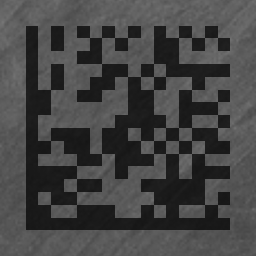

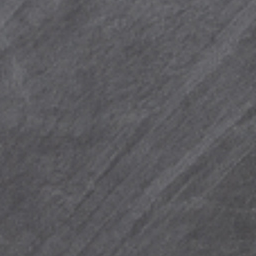

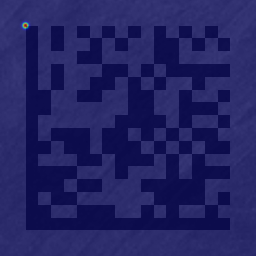

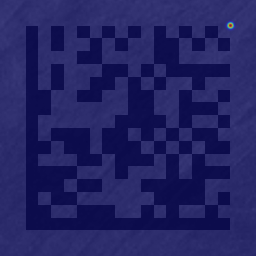

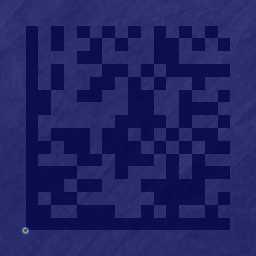

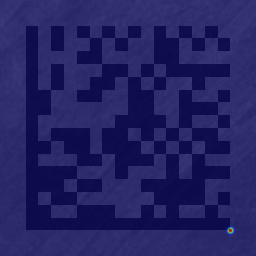

In [12]:
def combine_images(tensor):
    '''Combines DMC and texture tensors into one tensor'''
    dmc = tensor[:3].unsqueeze(0)
    texture = tensor[3:6].unsqueeze(0)

    # Increment black pixel intensity of DMC randomly
    increment = random.uniform(0.1, 0.5)
    dmc = torch.where(dmc < 0.5, dmc + increment, dmc)

    # Multiply DMC onto each texture channel
    texture = torch.mul(texture, dmc)

    # Remove batch dimension
    texture = texture.squeeze(0)

    return texture

test_tensor = load_test_file()
test_tensor[:3] = combine_images(test_tensor)
combined_dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A0O73069550055.pt


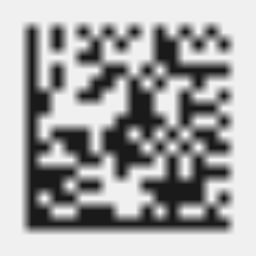

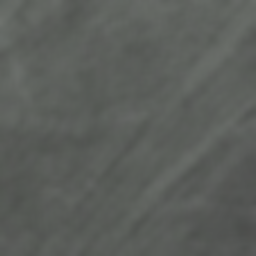

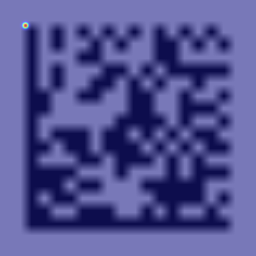

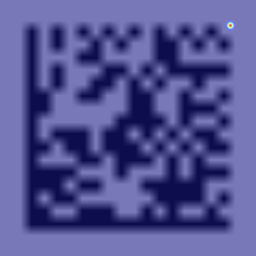

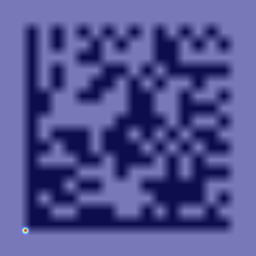

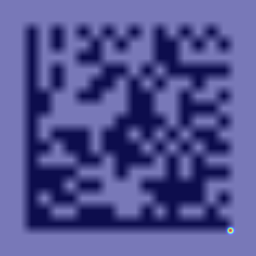

In [13]:
def color_transform(tensor):
    '''Applies random color transformations to image'''

    # Unsqueeze tensor to add batch dimension
    tensor = tensor.unsqueeze(0)

    # Random kernel size for gaussian blur
    kernel_size = random.choice([7, 9, 11])
    sharpness = random.uniform(0.5, 1.5)

    transforms = v2.Compose([
        # v2.ColorJitter(brightness = (0.5, 1.5),
        #                contrast   = (0.5, 1.5),
        #                saturation = (0.5, 1.5),
        #                hue        = (-0.5, 0.5),
        #                ),
        # v2.RandomChannelPermutation(),
        v2.RandomPhotometricDistort(brightness = (0.5, 1.5),
                                    contrast   = (0.5, 1.5),
                                    saturation = (0.5, 1.5),
                                    hue        = (-0.5, 0.5),
                                    ),
        v2.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 100.0)), # chance to blur a lot or a little - mostly an ok amount
        # v2.GaussianNoise(), # not implemented for PIL images
        # v2.RandomInvert(0.2), # lower chance of inversion # apply to code not background
        # v2.RandomPosterize(8),
        # v2.RandomSolarize(0.5, 0.5),
        v2.RandomAdjustSharpness(sharpness, 0.5),
        # v2.RandomAutocontrast(),
        # v2.RandomEqualize(0.2), # lower chance of equalization
    ])

    tensor = transforms(tensor)

    # Remove batch dimension
    tensor = tensor.squeeze(0)

    return tensor

# Testing color_transform
test_tensor = load_test_file()
test_tensor[:3] = color_transform(test_tensor[:3])
test_tensor[3:6] = color_transform(test_tensor[3:6])
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A0O73069550055.pt
DMC TEXTURE PAIR
SHAPE TRANSFORM
COMBINE IMAGES
COLOR TRANSFORM
FINAL SIZES
torch.Size([3, 256, 256])
torch.Size([4, 256, 256])


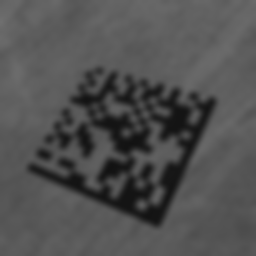

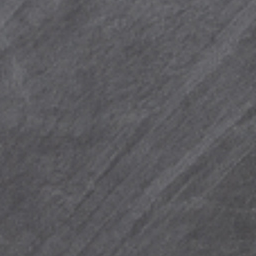

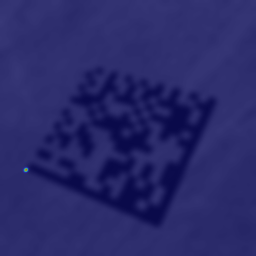

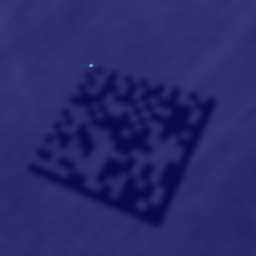

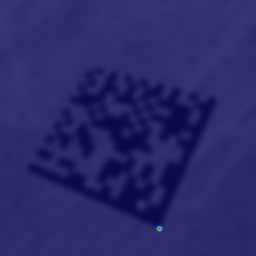

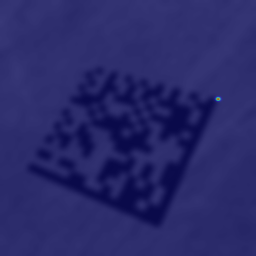

In [14]:
# Testing all transforms
test_tensor = load_test_file()

print('DMC TEXTURE PAIR')
# dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

print('SHAPE TRANSFORM')
test_tensor[:3], test_tensor[6:] = shape_transform(test_tensor)
# dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

print('COMBINE IMAGES')
dmc = combine_images(test_tensor)
# dmc_img, texture_img, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

print('COLOR TRANSFORM')
dmc = color_transform(dmc)

# Overwrite for the sake of seeing
test_tensor[:3] = dmc
print('FINAL SIZES')
print(dmc.shape)
print(test_tensor[6:].shape)
dmc_img, texture_img, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

In [15]:
# Helper function for resizing heatmaps
def resize_heatmaps(heatmaps, size):
    '''Resizes heatmaps to given size'''
    new_heatmaps = np.zeros((4, size, size))
    for i in range(4):
        heatmap = np.array(heatmaps[i])
        heatmap = cv2.resize(heatmap, (size, size))
        new_heatmaps[i] = heatmap

    # Convert to tensor
    new_heatmaps = torch.tensor(new_heatmaps).float()

    return new_heatmaps

torch.Size([8, 3, 256, 256])
torch.Size([8, 4, 64, 64])


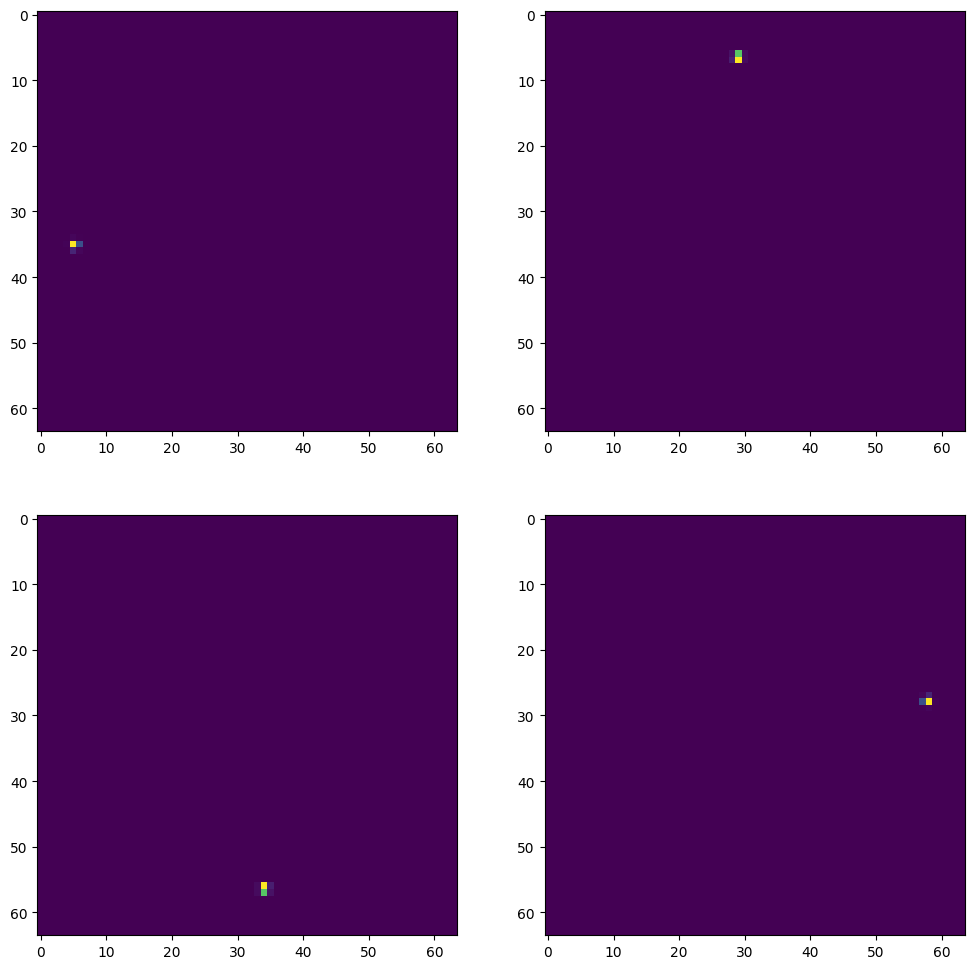

In [16]:
# Dataloader
class DMCDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, idx):
        # Load the tensor containing dmc, texture, and heatmaps
        tensor = torch.load(f'{self.image_dir}/{self.files[idx]}')

        # Shape transform dmc and heatmaps
        tensor[:3], tensor[6:] = shape_transform(tensor)

        # Combine dmc and texture pair
        dmc = combine_images(tensor)

        # Color transform dmc
        dmc = color_transform(dmc)

        # Resize heatmaps to output size
        heatmaps = resize_heatmaps(tensor[6:], output_size)

        return dmc, heatmaps

train_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/train',
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

# Testing dataloader
for dmc, heatmaps in train_loader:
    print(dmc.shape)
    print(heatmaps.shape)

    # Display dmc and heatmaps
    plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(heatmaps[0, i])
    plt.show()
    break

In [17]:
val_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/val',
)

val_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

test_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/test',
)

test_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
)

# Stacked Hourglass Setup

In [18]:
# Example usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=n_stacks,
    num_features=input_size,
    num_output_points=4,
)

for images, heatmaps in train_loader:
    print(images.shape)
    print(heatmaps.shape)
    output = model(images)
    print(output.shape) # Expected: (8, 4, H, W) representing 4 heatmaps per image
    break
print(output)

torch.Size([8, 3, 256, 256])
torch.Size([8, 4, 64, 64])
torch.Size([8, 4, 64, 64])
tensor([[[[-147.1944, -149.0263, -145.6129,  ..., -147.6102, -148.4899,
           -148.9814],
          [-147.8127, -148.2589, -145.3173,  ..., -147.0045, -148.7679,
           -149.3986],
          [-145.2045, -145.2183, -143.6612,  ..., -146.1834, -148.4688,
           -149.2967],
          ...,
          [-134.4987, -134.4957, -130.7596,  ..., -132.5409, -137.2594,
           -137.7127],
          [-138.9357, -138.7624, -134.8085,  ..., -137.2402, -138.1932,
           -137.8546],
          [-138.0618, -137.7686, -134.2867,  ..., -136.3867, -137.6083,
           -138.2160]],

         [[ -11.3026,  -10.6331,   -7.4432,  ...,  -11.8631,  -14.0728,
            -15.6022],
          [  -9.9886,  -10.6072,   -8.4188,  ...,  -13.2667,  -15.5674,
            -14.9660],
          [  -9.0153,   -8.9487,   -7.6024,  ...,  -14.6711,  -13.7634,
            -13.1326],
          ...,
          [ -16.4146,  -17.311

(4, 64, 64)


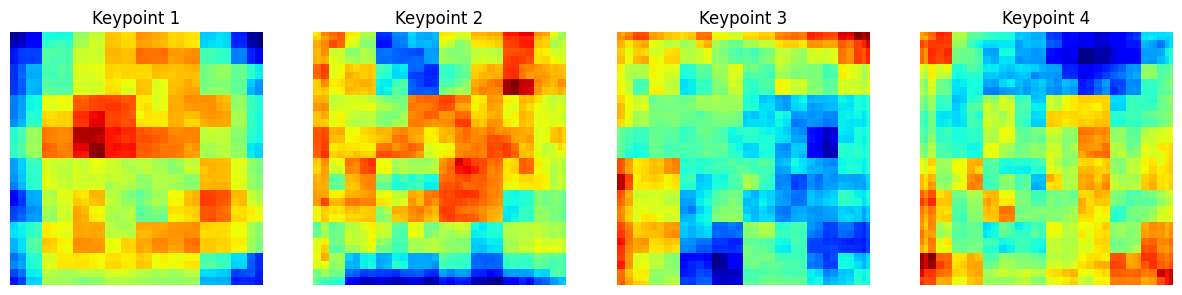

In [19]:
# Convert tensor to numpy for visualization
heatmaps = output[0].detach().cpu().numpy()  # Shape: (4, H, W)
print(heatmaps.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(heatmaps[i], cmap='jet')
    axes[i].set_title(f'Keypoint {i+1}')
    axes[i].axis('off')

plt.show()

In [20]:
def extract_keypoints(heatmaps, input_size, output_size):
    scale = input_size / output_size  # Scale factor to match original resolution
    keypoints = []
    for i in range(heatmaps.shape[0]):  # Iterate over keypoint heatmaps
        hmap = heatmaps[i]
        y, x = np.unravel_index(np.argmax(hmap), hmap.shape)  # Get max index
        keypoints.append((int(x * scale), int(y * scale)))  # Scale keypoints
    return keypoints

def heatmap_viz(image, keypoints, heatmaps, alpha=0.5):
    # Combined figure
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # Original image with keypoints
    image_kp = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert for OpenCV
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)] # Colors are blue, green, red, yellow (BGR)
    for i, (x, y) in enumerate(keypoints):
        cv2.circle(image_kp, (x, y), 5, colors[i], -1)  # Draw colored circle
    axes[0].imshow(cv2.cvtColor(image_kp, cv2.COLOR_BGR2RGB))
    axes[0].axis("off")
    axes[0].set_title("Image")

    # Heatmaps
    for i, heatmap in enumerate(heatmaps):
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to input image size
        heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())  # Normalize
        heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply color map
        overlay = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)  # Blend images
        axes[i+1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axes[i+1].axis("off")

        if i == 0:
            axes[i+1].set_title("Heatmap (blue)")
        elif i == 1:
            axes[i+1].set_title("Heatmap (green)")
        elif i == 2:
            axes[i+1].set_title("Heatmap (red)")
        elif i == 3:
            axes[i+1].set_title("Heatmap (yellow)")
    
    plt.show()

(4, 64, 64)
Predicted keypoints: [(0, 0), (184, 196), (80, 0), (8, 8)]


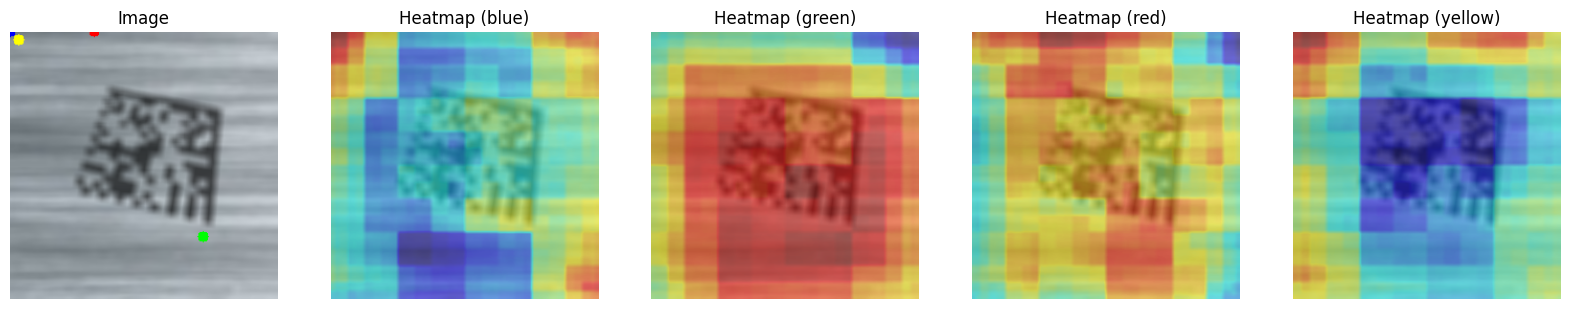

In [21]:
# Example vizualization usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=n_stacks,
    num_features=input_size,
    num_output_points=4,
)

for images, labels in train_loader:
    output = model(images)
    break

heatmaps = output[0].detach().cpu().numpy()  # Convert tensor to numpy
print(heatmaps.shape)
keypoints = extract_keypoints(heatmaps, input_size=input_size, output_size=output_size)
print("Predicted keypoints:", keypoints)

img = images[0].permute(1, 2, 0).numpy() * 255
img = img.astype(np.uint8) # Convert to ints only
heatmap_viz(img, keypoints, heatmaps)

(4, 64, 64)
True keypoints: [(116, 64), (200, 132), (52, 136), (144, 196)]


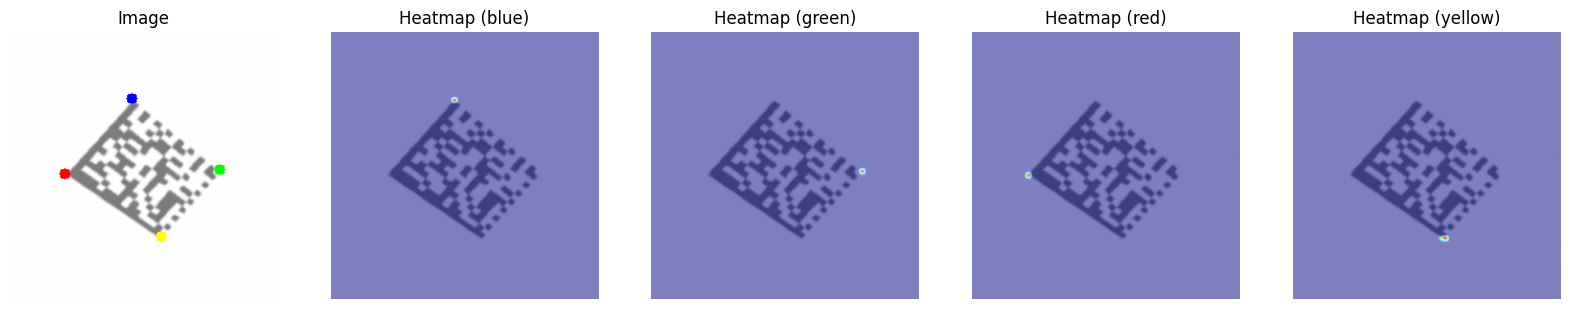

In [22]:
# Example vizualization of true keypoints and heatmaps
for images, labels in train_loader:
    image = images[0].permute(1, 2, 0).numpy() * 255
    image = image.astype(np.uint8) # Convert to ints only

    heatmaps = labels[0].detach().cpu().numpy()  # Convert tensor to numpy
    print(heatmaps.shape)
    keypoints = extract_keypoints(heatmaps, input_size=input_size, output_size=output_size)
    print('True keypoints:', keypoints)
    heatmap_viz(image, keypoints, heatmaps)
    break

# Model Training

In [23]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [24]:
# Training function
def train_model(model, early_stopper, train_loader, val_loader, epochs=10, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = {'train': [], 'val': []} # Store losses
    
    for epoch in range(epochs):
        model.train()

        train_loss = 0
        for images, heatmaps in train_loader:
            images, heatmaps = images.to(device), heatmaps.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        losses['train'].append(train_loss/len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        count = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, masks)

                val_loss += loss.item()

        losses['val'].append(val_loss/len(val_loader))

        # Early stopping if validation loss increases
        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch}')
            break

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.5f}, Val Loss: {val_loss/len(val_loader):.5f}')

    return model, losses

In [25]:
model = StackedHourglassNetwork(
    num_stacks=n_stacks,
    num_features=input_size,
    num_output_points=4,
)

print('Initial training...')
early_stopper = EarlyStopper(patience=3, min_delta=0.001)
initial_trained_model, trained_losses_tmp = train_model(model,
                                                        early_stopper,
                                                        train_loader,
                                                        val_loader,
                                                        epochs=10,
                                                        lr=0.001
                                                        )
trained_losses = trained_losses_tmp

print('Quick training...')
early_stopper = EarlyStopper(patience=5, min_delta=0.0001)
quick_trained_model, trained_losses_tmp = train_model(initial_trained_model,
                                                      early_stopper,
                                                      train_loader,
                                                      val_loader,
                                                      epochs=100,
                                                      lr=0.0001
                                                      )
trained_losses = {key: trained_losses[key] + trained_losses_tmp[key] for key in trained_losses.keys()}

print('Touch up training...')
early_stopper = EarlyStopper(patience=10, min_delta=0.0001)
touchup_trained_model, trained_losses_tmp = train_model(quick_trained_model,
                                                        early_stopper,
                                                        train_loader,
                                                        val_loader,
                                                        epochs=100,
                                                        lr=0.00001
                                                        )
trained_losses = {key: trained_losses[key] + trained_losses_tmp[key] for key in trained_losses.keys()}

print('Final training...')
early_stopper = EarlyStopper(patience=10, min_delta=0.00001)
final_trained_model, trained_losses_tmp = train_model(touchup_trained_model,
                                                      early_stopper,
                                                      train_loader,
                                                      val_loader,
                                                      epochs=100,
                                                      lr=0.000001
                                                      )
trained_losses = {key: trained_losses[key] + trained_losses_tmp[key] for key in trained_losses.keys()}

print('Training complete!')

Initial training...
Epoch 1/10, Train Loss: 5295.84943, Val Loss: 79.39466
Epoch 2/10, Train Loss: 48.22312, Val Loss: 9.70388
Epoch 3/10, Train Loss: 16.48460, Val Loss: 9.99211
Epoch 4/10, Train Loss: 10.72119, Val Loss: 6.88227
Epoch 5/10, Train Loss: 8.42222, Val Loss: 5.14031
Epoch 6/10, Train Loss: 5.26264, Val Loss: 3.36920
Epoch 7/10, Train Loss: 4.30878, Val Loss: 2.79490
Epoch 8/10, Train Loss: 3.64663, Val Loss: 1.67392
Epoch 9/10, Train Loss: 2.98203, Val Loss: 2.13533
Epoch 10/10, Train Loss: 2.77863, Val Loss: 1.71331
Quick training...
Epoch 1/100, Train Loss: 12.35787, Val Loss: 4.40224
Epoch 2/100, Train Loss: 5.97672, Val Loss: 5.84132
Epoch 3/100, Train Loss: 4.06555, Val Loss: 3.63122
Epoch 4/100, Train Loss: 2.31072, Val Loss: 6.08828
Epoch 5/100, Train Loss: 2.42846, Val Loss: 5.61389
Epoch 6/100, Train Loss: 2.44320, Val Loss: 4.71894
Epoch 7/100, Train Loss: 2.07934, Val Loss: 0.80905
Epoch 8/100, Train Loss: 1.40607, Val Loss: 1.10407
Epoch 9/100, Train Loss: 0.

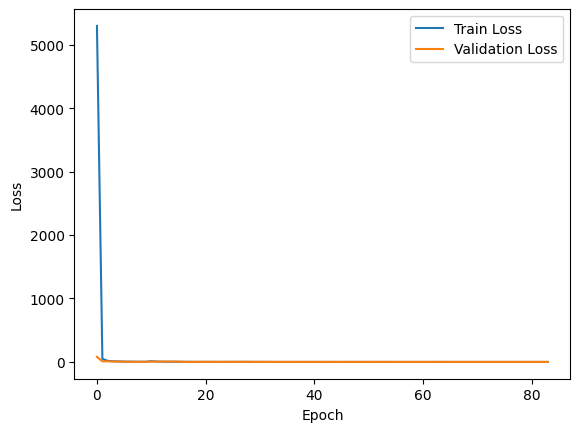

In [26]:
# Show training and validation losses
plt.plot(trained_losses['train'], label='Train Loss')
plt.plot(trained_losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation

In [27]:
def evaluate_model(model, loader):
    model.eval()

    criterion = nn.MSELoss()

    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            count += 1
        
    print(f'Average loss: {total_loss/count:.4f}')

    return total_loss

In [28]:
# Train loss
evaluate_model(final_trained_model, train_loader)

Average loss: 0.1457


1.0196308642625809

In [29]:
# Val loss
evaluate_model(final_trained_model, val_loader)

Average loss: 0.1355


0.9487874433398247

In [30]:
# Test loss
evaluate_model(final_trained_model, test_loader)

Average loss: 0.1460


1.0216733068227768

In [58]:
def compare_keypoints(model, loader):
    model.eval()

    with torch.no_grad():
        for images, true_heatmaps in loader:
            images, true_heatmaps = images.to(device), true_heatmaps
            break

        outputs = model(images)
        outputs = outputs.detach().cpu().numpy()
        true_heatmaps = true_heatmaps.numpy()

        for i in range(len(images)):
            img = images[i].permute(1, 2, 0).cpu().numpy() * 255
            img = img.astype(np.uint8) # Convert to ints only

            pred_keypoints = extract_keypoints(outputs[i], input_size=input_size, output_size=output_size)
            true_keypoints = extract_keypoints(true_heatmaps[i], input_size=input_size, output_size=output_size)

            print(f'Predicted keypoints: {pred_keypoints}')
            heatmap_viz(img, pred_keypoints, outputs[i])

            print(f'True keypoints: {true_keypoints}')
            heatmap_viz(img, true_keypoints, true_heatmaps[i])

            break
    
    return

## Train Print

Predicted keypoints: [(192, 192), (196, 96), (128, 92), (180, 212)]


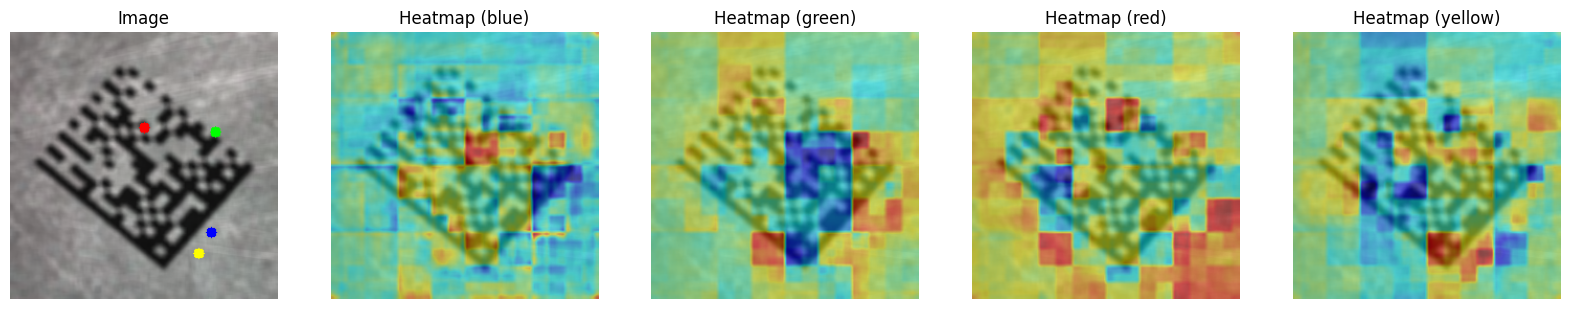

True keypoints: [(20, 124), (108, 24), (144, 228), (232, 128)]


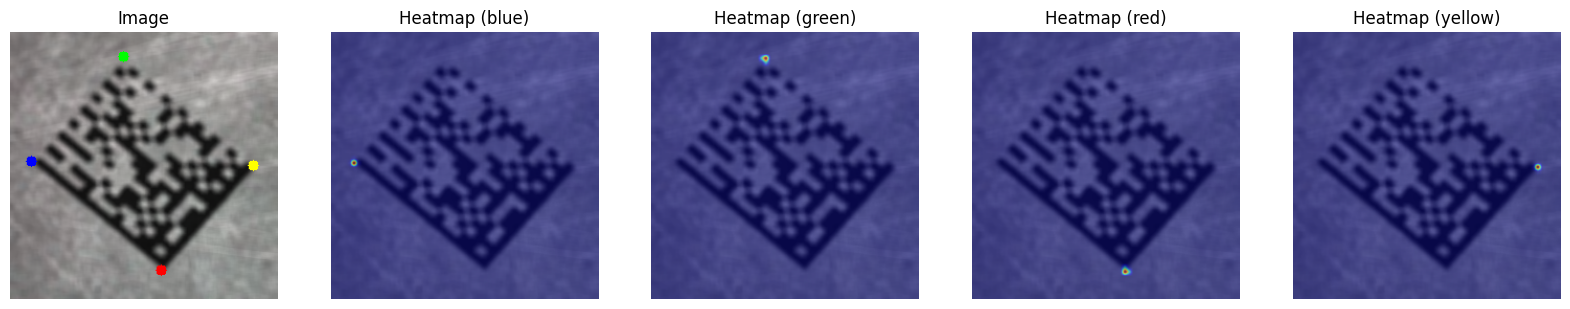

In [61]:
compare_keypoints(final_trained_model, train_loader)

## Validation Print

Predicted keypoints: [(200, 128), (184, 192), (16, 132), (192, 196)]


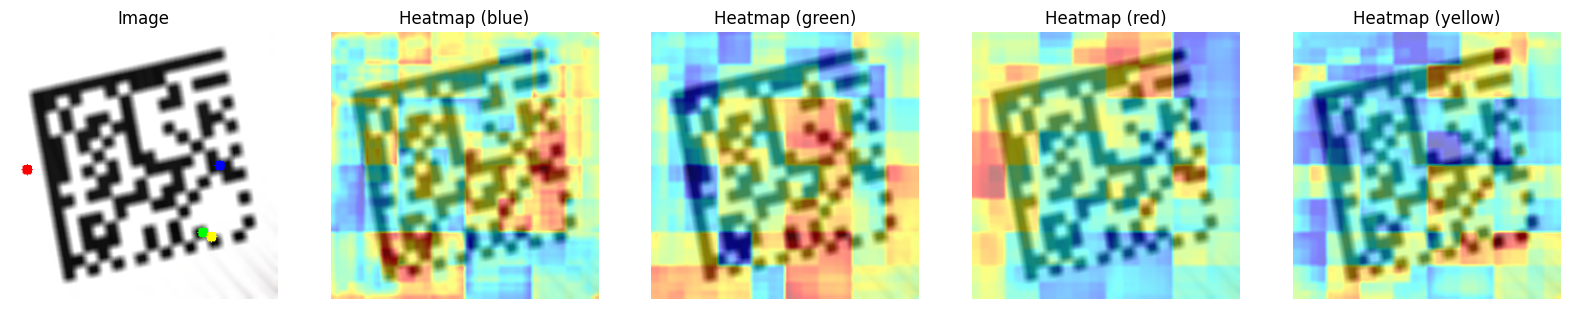

True keypoints: [(204, 12), (236, 196), (16, 56), (48, 240)]


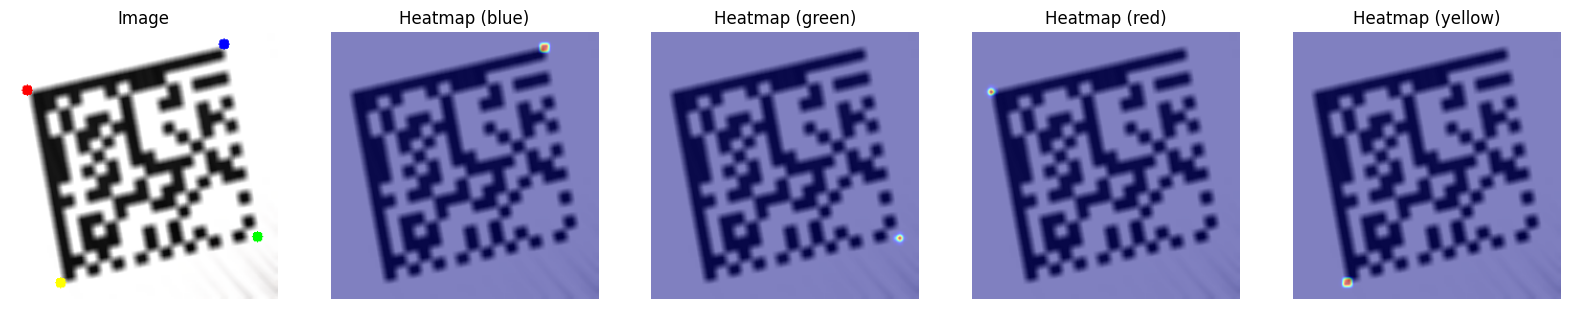

In [62]:
compare_keypoints(final_trained_model, val_loader)

## Test Print

Predicted keypoints: [(64, 84), (152, 112), (124, 140), (52, 88)]


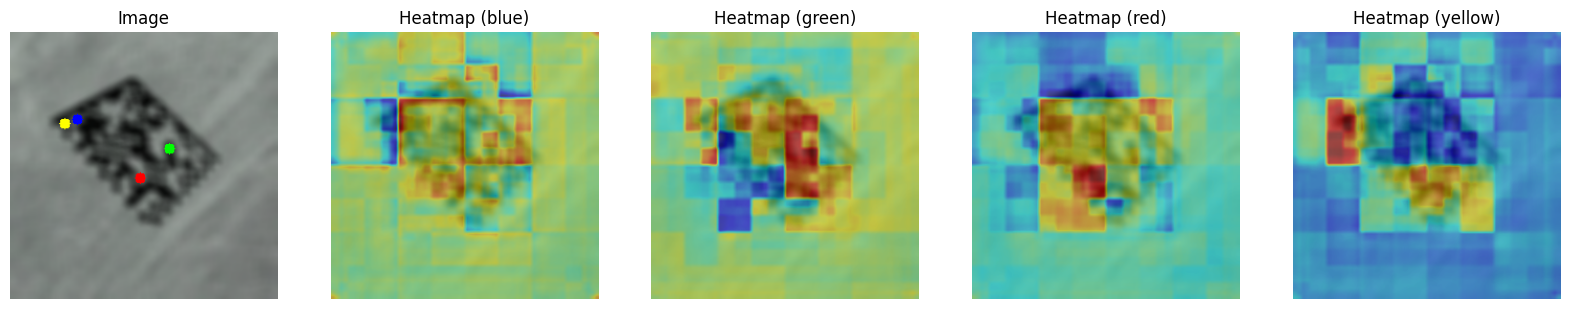

True keypoints: [(200, 120), (132, 188), (116, 40), (36, 84)]


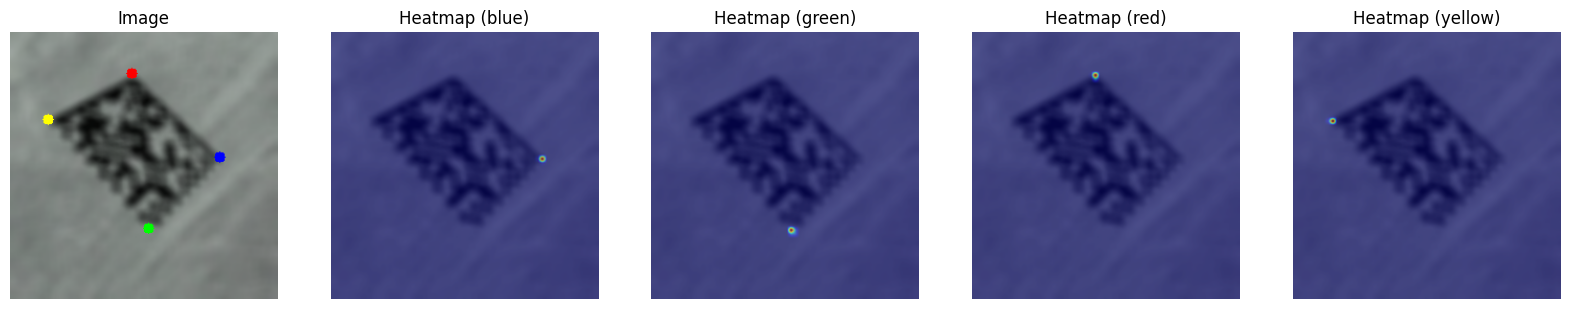

In [63]:
compare_keypoints(final_trained_model, test_loader)

# Saving Model(s)

In [34]:
# Save all models
torch.save(initial_trained_model.state_dict(), '../models/hourglass_localization_rectification/initial_trained_model.pth')
torch.save(quick_trained_model.state_dict(), '../models/hourglass_localization_rectification/quick_trained_model.pth')
torch.save(touchup_trained_model.state_dict(), '../models/hourglass_localization_rectification/touchup_trained_model.pth')
torch.save(final_trained_model.state_dict(), '../models/hourglass_localization_rectification/final_trained_model.pth')